
<a href="https://github.com/wgova/Coursera_Capstone/blob/master/Business%20problem.pptx"><img src = "https://github.com/wgova/Coursera_Capstone/blob/master/13299245.jpg" width = 400, align = "center"></a>
# <center>Travel agent toolkit - Central Toronto</center>


### 1. Download dataframe for Toronto boroughs

The geolocation dataframe for Toronto boroughs was developed in this this notebook:
[Extracting Toronto boroughs from Wikipedia](https://github.com/wgova/Coursera_Capstone/blob/master/Recommender%20-%20Central%20Toronto%20Accomodation/Notebooks/Segmenting%20Toronto%20-%20Geotagged%20map.ipynb)

In [1]:
#!conda install -c conda-forge geopy --yes

In [2]:
#!conda install -c conda-forge folium=0.5.0 --yes
#!conda install seaborn -c conda-forge --yes
#!conda install -c anaconda seaborn

In [4]:
# Data wrangling modules
import io
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

Import plotting libraries

In [5]:
import json # For handling JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium # Map rendering library 
import seaborn as sns
import matplotlib.pyplot as plt

Fetch **Borough** data from dataframe from Github

In [6]:
url = 'https://raw.githubusercontent.com/wgova/Coursera_Capstone/master/Recommender%20-%20Central%20Toronto%20Accomodation/Data/toronto_df.csv'
toronto_df = pd.read_csv(url)
toronto_df.head(3)

,Unnamed: 0,Postalcode,Borough,Neighbourhood,Latitude,Longitude
0,0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711


In [6]:
print('Uniques Boroughs: {} .'.format(len(toronto_df['Borough'].unique())))
print('List of different categories:')
toronto_df['Borough'].unique()

Uniques Boroughs: 11 .
List of different categories:


array(['Scarborough', 'North York', 'East York', 'East Toronto',
       'Central Toronto', 'Downtown Toronto', 'York', 'West Toronto',
       "Queen's Park", 'Mississauga', 'Etobicoke'], dtype=object)

In [7]:
#x_ticks = ['Scarborough','North York','East York','East Toronto','Central Toronto','Downtown Toronto','York','West Toronto',
#           "Queen's Park",'Mississauga','Etobicoke']
totals = toronto_df.groupby(['Borough']).Neighbourhood.count()
totals_df = pd.DataFrame(totals)
totals_df.head(100)

,Neighbourhood
Borough,
Central Toronto,9
Downtown Toronto,18
East Toronto,5
East York,5
Etobicoke,12
Mississauga,1
North York,24
Queen's Park,1
Scarborough,17


An overview of the number of neighbourhoods in each Borough

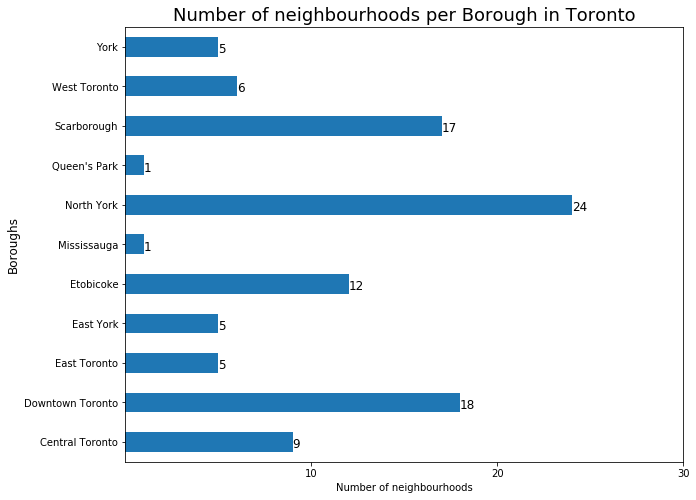

In [8]:
scores = toronto_df.groupby(['Borough']).Neighbourhood.count()
ax = totals_df.plot(kind='barh',legend = False, figsize=(10,8))
ax.set_alpha(0.1)
ax.set_title("Number of neighbourhoods per Borough in Toronto", fontsize=18);
ax.set_xlabel("Number of neighbourhoods", fontsize=10)
ax.set_ylabel("Boroughs",fontsize=12)
ax.set_xticks([10,20,30])
#ax.set_yticklabels(totals_df['Borough'])
# set individual bar labels using 'yticklabels'
for i in ax.patches:
                   ax.text(i.get_width(), i.get_y()+0.1, \
                           str(round((i.get_width()), 2)), fontsize=12, color='black',rotation=0)
# invert for largest on top 
#ax.invert_yaxis()

Plot geotagged map of Toronto with Toronto Boroughs markers 

In [9]:
# create empty map of Toronto using latitude and longitude values
lat = 43.7615390 ; lon = -79.411079
Toronto_boroughs_map = folium.Map(location=[lat, lon], zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_df['Latitude'], toronto_df['Longitude'], 
                           toronto_df['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Toronto_boroughs_map)  
    
Toronto_boroughs_map

In [10]:
#Central Toronto

# selecting only neighborhoods in 'Central Toronto' borough.
toronto = toronto_df[toronto_df['Borough'] == 'Central Toronto']
toronto = toronto.reset_index(drop=True).drop(columns = 'Unnamed: 0')
toronto.head()

,Postalcode,Borough,Neighbourhood,Latitude,Longitude
0,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
1,M4P,Central Toronto,Davisville North,43.712751,-79.390197
2,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
3,M4S,Central Toronto,Davisville,43.704324,-79.388790
4,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160


### 2. Make an API call to Foursquare to get information on venues in Central Toronto

In [11]:
Client_ID = 'V1IHZGU2XZ2XAEHV0G3EZIVIQTFFLCMPWNI3I3LRUL3PYRAA'
Client_Secret = 'OSMB212BOD4NKSCN4IYRRIAFOAFVTEO0KM0EJ1245PK0O0QJ'
Version = '20181026'

Define a function to fetch coordinates from FOURSQUARE

In [12]:
def api_call_4sqr (postal_code_list, neighbourhood_list, lat_list, lng_list, LIMIT = 50000, radius = 10000):
    api = []
    counter = 0
    for postal_code, neighbourhood, lat, lng in zip(postal_code_list, neighbourhood_list, lat_list, lng_list):
         
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            Client_ID, Client_Secret, Version, 
            lat, lng, radius, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        api_dict = {}
        api_dict['Postalcode'] = postal_code; api_dict['Neighbourhood(s)'] = neighbourhood; 
        api_dict['Latitude'] = lat; api_dict['Longitude'] = lng;
        api_dict['API_calls'] = results;
        api.append(api_dict)
        counter += 1
    return api;

In [13]:
Toronto_4sqr = api_call_4sqr(list(toronto['Postalcode']),list(toronto['Neighbourhood']),
                             list(toronto['Latitude']),list(toronto['Longitude']),)

In [14]:
#Use pickle to pickle results and store them in local drive
import pickle
with open("Toronto_4sqr.txt", "wb") as fp:   
    pickle.dump(Toronto_4sqr, fp)
#Unpickle results
with open("Toronto_4sqr.txt", "rb") as fp:   
    Toronto_4sqr = pickle.load(fp)

print("Foursquare API call results saved in: ")
%pwd

Foursquare API call results saved in: 


'C:\\Users\\Mecer\\Coursera\\Data Science Professional\\Machine learning'

Plot the map of Central Toronto superimposed onto the one for Toronto

In [15]:
from folium import IFrame
#lat = 43.72021610 ; lon = -79.5395769
#map_Toronto_Central = folium.Map(location=[lat, lon], zoom_start=10.5)

# Add a popup label for the map
text = 'Boroughs in Central Toronto'
iframe = folium.IFrame(text, width=700, height=50)
popup = folium.Popup(iframe, max_width=1000)
Text = folium.Marker(location=[lat,lon], popup=popup,
                     icon=folium.Icon(icon_color='red'))

# add markers to map
for lat, lng, label in zip(toronto['Latitude'], toronto['Longitude'], toronto['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng], radius = 6, popup = label, color ='red', fill = True,fill_color = '#3186cc',
        fill_opacity = 0.7).add_to(Toronto_boroughs_map)

#Toronto_boroughs_map.add_child(Text)
#Toronto_boroughs_map.save('dToronto_Central.html')
#Toronto_boroughs_map
Toronto_boroughs_map.save('Toronto_Central.html')
Toronto_boroughs_map


### Data cleaning to convert the raw Foursquare data into dataframes 

In [16]:
# Function to create dataframe
def venues_results(Toronto_4sqr):
    venues_df = pd.DataFrame(columns = ['Postalcode', 'Neighbourhood','Latitude', 'Longitude','Venue', 
                                        'Tips for venue', 'Venue Category', 'Distance'])
    
    for hood_dict in Toronto_4sqr: # Store neighborhood names in a dictionary
        postal_code = hood_dict['Postalcode']; 
        hood = hood_dict['Neighbourhood(s)'];
        lat = hood_dict['Latitude']; 
        lon = hood_dict['Longitude']
                
        for venue_dict in hood_dict['API_calls']: #Store venue names in a dictionary
            summary = venue_dict['reasons']['items'][0]['summary']
            name = venue_dict['venue']['name']
            distance = venue_dict['venue']['location']['distance']
            category =  venue_dict['venue']['categories'][0]['name']
            
            venues_df = venues_df.append({
                'Postalcode': postal_code, 'Neighbourhood': hood,'Latitude': lat, 'Longitude':lon,
                'Venue': name, 'Tips for venue': summary,'Venue Category': category, 'Distance': distance
            },ignore_index = True)
    return(venues_df)

In [17]:
venues_toronto = venues_results(Toronto_4sqr)
venues_toronto.nunique()

Postalcode          9
Neighbourhood       9
Latitude            9
Longitude           7
Venue             151
Tips for venue      1
Venue Category     78
Distance          836
dtype: int64

In [18]:
venues = venues_toronto['Venue'].unique()
venues = len(venues) ; print('Venues:',venues)
hoods = venues_toronto['Neighbourhood'].unique()
#print(hoods)
hoods = len(hoods) ; print('Neighbourhoods:', hoods)

Venues: 151
Neighbourhoods: 9


Save a copy of the dataframe results to a csv file

In [19]:
venues_toronto.to_csv('Tips - Central Toronto.csv')
venues_toronto.tail(3)

,Postalcode,Neighbourhood,Latitude,Longitude,Venue,Tips for venue,Venue Category,Distance
897,M5R,"The Annex, North Midtown, Yorkville",43.67271,-79.405678,Union Restaurant,This spot is popular,French Restaurant,3190
898,M5R,"The Annex, North Midtown, Yorkville",43.67271,-79.405678,NADÈGE,This spot is popular,Bakery,3038
899,M5R,"The Annex, North Midtown, Yorkville",43.67271,-79.405678,Gusto 101,This spot is popular,Italian Restaurant,3116


Create a venues dataframe for venues in Central Toronto

In [20]:
#venues_ct = pd.merge(venues_toronto, toronto, on='Postalcode')
venues_ct = venues_toronto.merge(toronto[['Latitude', 'Longitude']], how = 'left')
#venues_ct = venues_ct.reset_index(drop=True).drop(columns = 'Unnamed: 0')
null = venues_ct.isnull().values.any() ; print('Null values: ', null)
venues_ct['Venue'].count()

Null values:  False


900

In [39]:
from folium import IFrame
#lat = 43.72021610 ; lon = -79.5395769
map_Toronto_Central = folium.Map(location=[lat, lon], zoom_start=11.5)

# Add a popup label for the map
text = 'Venues in neighbourhoods around Central Toronto'
iframe = folium.IFrame(text, width=500, height=50)
popup = folium.Popup(iframe, max_width=700)
Text = folium.Marker(location=[lat,lon], popup=popup,
                     icon=folium.Icon(icon_color='orange'))

# add markers to map
for lat, lng, label in zip(toronto['Latitude'], toronto['Longitude'], venues_ct['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng], radius = 6, popup = label, color ='orange', fill = True,fill_color = '#3186cc',
        fill_opacity = 0.7).add_to(Toronto_boroughs_map)

Toronto_boroughs_map.add_child(Text)
map_Toronto_Central.save('Venues Toronto_Central.html')
Toronto_boroughs_map

All the neighbourghhoods around Central Toronto have at least one venue desired by the students on their trip. Load the venues dataframe for further analysis

In [22]:
venues_ct.rename(columns={'Venue Category':'Category'}, inplace=True)
venues_ct.head()

,Postalcode,Neighbourhood,Latitude,Longitude,Venue,Tips for venue,Category,Distance
0,M4N,Lawrence Park,43.72802,-79.38879,Sherwood Park,This spot is popular,Park,1279
1,M4N,Lawrence Park,43.72802,-79.38879,Istanbul Cafe & Espresso Bar,This spot is popular,Café,2266
2,M4N,Lawrence Park,43.72802,-79.38879,Edwards Gardens,This spot is popular,Park,2527
3,M4N,Lawrence Park,43.72802,-79.38879,Auberge du Pommier,This spot is popular,French Restaurant,2608
4,M4N,Lawrence Park,43.72802,-79.38879,Sunnybrook Park,This spot is popular,Other Great Outdoors,2752


In [23]:
#venues_ct['Category'].unique()

In [24]:
cat_totals = venues_ct.groupby(['Neighbourhood']).Category.value_counts()
cat_totals_df = pd.DataFrame(cat_totals)
cat_totals_df.head(10)
cat_totals_df.count()

Category    553
dtype: int64

Summary of venue categories to show the variety of categories per neighbourhood in Central Toronto. 

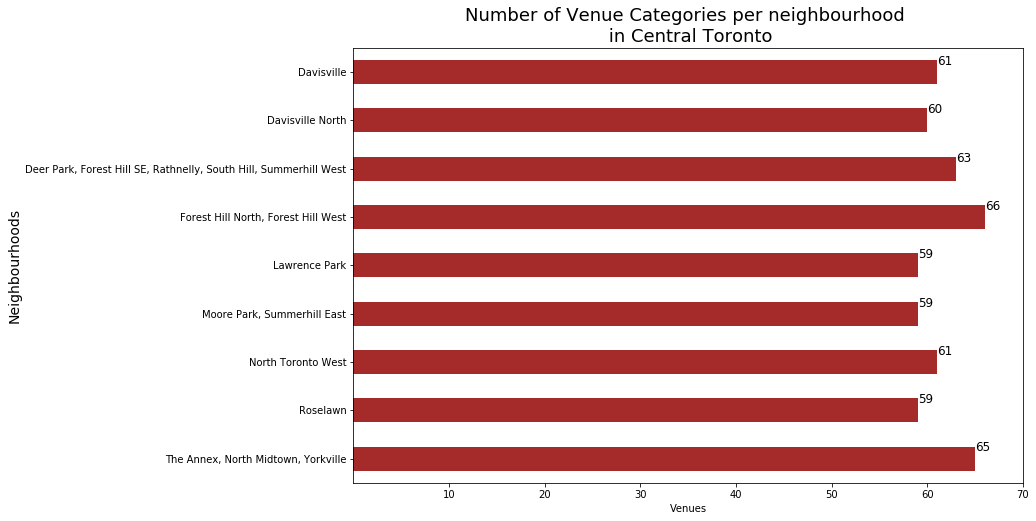

In [25]:
#scores = venues_ct.groupby(['Neighbourhood']).Venue.nunique()
scores = venues_ct.groupby(['Neighbourhood']).Category.nunique()
ax = scores.plot(kind='barh',legend = False,color='brown', figsize=(12,8))
ax.set_alpha(0.1)
ax.set_title("Number of Venue Categories per neighbourhood \n in Central Toronto", fontsize=18);
ax.set_xlabel("Venues", fontsize=10)
ax.set_ylabel("Neighbourhoods",fontsize=14)
ax.set_xticks([10,20,30,40,50,60,70])
#ax.set_yticklabels(totals_df['Borough'])
# set individual bar labels using 'yticklabels'
for i in ax.patches:
                   ax.text(i.get_width(), i.get_y()+0.1, \
                           str(round((i.get_width()), 2)), fontsize=12, color='black',rotation=0)
# invert for largest on top 
ax.invert_yaxis()

Load the clean, pre-processed dataset of venues downloaded from Foursquare

In [26]:
venues_toronto = pd.read_csv('Tips - Central Toronto.csv')
#list(venues_toronto['Venue Category'].unique())
venues_toronto.rename(columns={'Venue Category':'Category'}, inplace=True)
venues_toronto = venues_toronto.reset_index(drop=True).drop(columns = 'Unnamed: 0')
venues_toronto.head()

,Postalcode,Neighbourhood,Latitude,Longitude,Venue,Tips for venue,Category,Distance
0,M4N,Lawrence Park,43.72802,-79.38879,Sherwood Park,This spot is popular,Park,1279
1,M4N,Lawrence Park,43.72802,-79.38879,Istanbul Cafe & Espresso Bar,This spot is popular,Café,2266
2,M4N,Lawrence Park,43.72802,-79.38879,Edwards Gardens,This spot is popular,Park,2527
3,M4N,Lawrence Park,43.72802,-79.38879,Auberge du Pommier,This spot is popular,French Restaurant,2608
4,M4N,Lawrence Park,43.72802,-79.38879,Sunnybrook Park,This spot is popular,Other Great Outdoors,2752


Hot code the data to reflect whather specific venues are available in a Borough or not 

In [27]:
# one hot encoding
venues_toronto_hc = pd.get_dummies(data = venues_toronto, drop_first  = False, 
                              prefix = "", prefix_sep = "", columns = ['Category'])
venues_toronto_hc['Neighborhood'].value_counts()
venues_toronto_hc.head(3)
#venues_toronto['Category'].unique()

,Postalcode,Neighbourhood,Latitude,Longitude,Venue,Tips for venue,Distance,American Restaurant,Art Gallery,Arts & Crafts Store,...,Sporting Goods Shop,Steakhouse,Street Art,Taco Place,Tapas Restaurant,Thai Restaurant,Theater,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar
0,M4N,Lawrence Park,43.72802,-79.38879,Sherwood Park,This spot is popular,1279,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M4N,Lawrence Park,43.72802,-79.38879,Istanbul Cafe & Espresso Bar,This spot is popular,2266,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M4N,Lawrence Park,43.72802,-79.38879,Edwards Gardens,This spot is popular,2527,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Update dataframe with hotcodes for activities, facilities and amenities the students want access on their trip

In [28]:
activities = ['Neighbourhood',
              'Park', 'Café', 'French Restaurant', 'Other Great Outdoors','Fish & Chips Shop', 
              'Gastropub', 'BBQ Joint','Japanese Restaurant','History Museum', 'Grocery Store',
              'Field', 'Liquor Store', 'Coffee Shop', 'Spa', 'Historic Site','Farmers Market', 
              'Shopping Mall', 'Juice Bar', 'Castle','Italian Restaurant', 'Indian Restaurant',
              'Greek Restaurant', 'Ice Cream Shop', 'Museum', 'Thai Restaurant','Pizza Place', 
              'Gift Shop','Concert Hall', 'Steakhouse', 'Vegetarian / Vegan Restaurant',
              'Breakfast Spot', 'American Restaurant', 'Restaurant','Indie Movie Theater', 
              'Dessert Shop','Bar','Sandwich Place', 'Hostel', 'Cocktail Bar','Cupcake Shop',
              'Tapas Restaurant', 'South American Restaurant','Vietnamese Restaurant', 
              'Mexican Restaurant','Ramen Restaurant','Egyptian Restaurant','Theater','Movie Theater', 
              'Burrito Place','Arts & Crafts Store', 'Taco Place', 'Organic Grocery','Plaza',
              'Beer Bar', 'Whisky Bar','Middle Eastern Restaurant', 'Mediterranean Restaurant',
              'Cosmetics Shop', 'Diner','Seafood Restaurant', 'Asian Restaurant', 'Korean Restaurant'
             ]

venues = venues_toronto_hc[activities].groupby('Neighbourhood').sum()
venues.head(3)

,Park,Café,French Restaurant,Other Great Outdoors,Fish & Chips Shop,Gastropub,BBQ Joint,Japanese Restaurant,History Museum,Grocery Store,...,Plaza,Beer Bar,Whisky Bar,Middle Eastern Restaurant,Mediterranean Restaurant,Cosmetics Shop,Diner,Seafood Restaurant,Asian Restaurant,Korean Restaurant
Neighbourhood,,,,,,,,,,,,,,,,,,,,,
Davisville,6,11,2,1,1,3,2,2,1,3,...,1,0,0,0,0,0,0,0,0,0
Davisville North,7,11,2,1,1,3,2,3,1,3,...,1,0,0,0,0,0,0,0,0,0
"Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West",5,10,1,0,1,3,1,2,0,3,...,1,1,1,0,1,1,1,0,0,0


## Fitting the data to the k-means model

In [29]:
from sklearn.cluster import KMeans

# Fit the data to the k-means clustering model
kmeans = KMeans(n_clusters = 5, random_state = 0).fit(venues)

In [30]:
means_df = pd.DataFrame(kmeans.cluster_centers_)
means_df.columns = venues.columns
means_df.index = ['Cluster_1','Cluster_2','Cluster_3','Cluster_4','Cluster_5']
means_df['Sum'] = means_df.sum(axis = 1)
mean = means_df['Sum']
means_df.sort_values(axis = 0, by = ['Sum'], ascending=False).reset_index()
means_df.index.name = 'Cluster'
means_df

,Park,Café,French Restaurant,Other Great Outdoors,Fish & Chips Shop,Gastropub,BBQ Joint,Japanese Restaurant,History Museum,Grocery Store,...,Beer Bar,Whisky Bar,Middle Eastern Restaurant,Mediterranean Restaurant,Cosmetics Shop,Diner,Seafood Restaurant,Asian Restaurant,Korean Restaurant,Sum
Cluster,,,,,,,,,,,,,,,,,,,,,
Cluster_1,5.000000,11.0,2.0,1.0,1.0,3.0,2.000000,2.0,0.0,3.0,...,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,87.0
Cluster_2,2.000000,8.0,2.0,0.0,0.0,1.0,1.000000,1.0,0.0,3.0,...,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,1.0,85.0
Cluster_3,8.500000,9.5,1.5,1.0,1.0,3.5,2.000000,3.0,0.5,3.0,...,1.0,1.0,0.5,0.0,0.0,0.0,0.5,1.0,0.0,90.0
Cluster_4,7.333333,11.0,2.0,1.0,1.0,3.0,2.333333,3.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0
Cluster_5,5.000000,9.5,1.0,0.5,1.0,3.0,1.500000,2.0,0.0,3.0,...,1.0,1.0,0.5,0.5,1.0,0.5,0.0,1.0,0.5,89.0


Attach k.means labels to 'hot-coded' venues dataset according to categories

## Making a recommendation

The top 3 neighbourhoods are in Cluster_3, then Cluster_5, followed by Cluster_4 based on the **Sum** of the k-means scores. The next step is to make a recommendation on neighbourhoods based on these k-means clusters around venue categories.

In [31]:
nb_summary = pd.DataFrame([venues.index, 1 + kmeans.labels_]).T
nb_summary.columns = ['Neighbourhood', 'Cluster']
nb_summary

,Neighbourhood,Cluster
0,Davisville,4
1,Davisville North,4
2,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",5
3,"Forest Hill North, Forest Hill West",5
4,Lawrence Park,4
5,"Moore Park, Summerhill East",1
6,North Toronto West,3
7,Roselawn,3
8,"The Annex, North Midtown, Yorkville",2


## The best neighbourhoods are: 

In [32]:
nb_names1 = nb_summary[nb_summary['Cluster'] == 3]
nb_names1.head()

,Neighbourhood,Cluster
6,North Toronto West,3
7,Roselawn,3


## The second best neighbourhoods are: 

In [33]:
nb_names2 = nb_summary[nb_summary['Cluster'] == 5]
nb_names2.head()

,Neighbourhood,Cluster
2,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",5
3,"Forest Hill North, Forest Hill West",5


## The third best neighbourhoods are: 

In [34]:
nb_names3 = nb_summary[nb_summary['Cluster'] == 4]
nb_names3.head()

,Neighbourhood,Cluster
0,Davisville,4
1,Davisville North,4
4,Lawrence Park,4


In [35]:
prefs_df1 = nb_names1.merge(venues_toronto[['Neighbourhood','Latitude','Longitude']], on='Neighbourhood')
prefs_df2 = nb_names2.merge(venues_toronto[['Neighbourhood','Latitude','Longitude']], on='Neighbourhood')
prefs_df = prefs_df1.append(prefs_df2, ignore_index=False)
prefs_df.nunique()

Neighbourhood    4
Cluster          2
Latitude         4
Longitude        4
dtype: int64

Map of the 3 best neighbourhoods in Central Toronto to find students accomodation on their summer trip

In [41]:
from folium import IFrame
#lat = 43.72021610 ; lon = -79.5395769
#map_Toronto_Central = folium.Map(location=[lat, lon], zoom_start=10.5)

# Add a popup label for the map
text = 'Ideal neighbourhoods to stay in Central Toronto'
iframe = folium.IFrame(text, width=300, height=50)
popup = folium.Popup(iframe, max_width=500)
Text = folium.Marker(location=[lat,lon], popup=popup,
                     icon=folium.Icon(icon_color='green'))

# add markers to map
for lat, lng, label in zip(prefs_df1['Latitude'], prefs_df1['Longitude'], prefs_df1['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng], radius = 6, popup = label, color ='green', fill = True,fill_color = '#3186cc',
        fill_opacity = 0.7).add_to(Toronto_boroughs_map)

Toronto_boroughs_map.add_child(Text)
Toronto_boroughs_map.save('Destination Toronto_Central.html')
Toronto_boroughs_map
